## In this notebook, we use Care for pair wise training. We ignore the middle slices (30 to 40) and also the extreme slices (0 to 5, 65 to 70)


In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
import glob
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
import copy


Using TensorFlow backend.


## Load Input and Output Data 

In [2]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print(len(imgs))
print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

10
Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the latter half of the z-slices as input from CM02

In [3]:
X_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][40:65, ...]
    X_CM02.append(temp)
print(X_CM02[5].shape)

(25, 896, 576)


In [4]:
Y_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][5:30, ...]
    Y_CM02.append(temp)
print(Y_CM02[5].shape)

(25, 896, 576)


## Load images from CM03

In [5]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the first half of the z-slices from CM03

In [6]:
X_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][5:30, ...]
    X_CM03.append(temp)
print(X_CM03[5].shape)

(25, 896, 576)


In [7]:
Y_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][40:65, ...]
    Y_CM03.append(temp)
print(Y_CM03[5].shape)

(25, 896, 576)


## Combine X_CM02 and X_CM03

In [8]:
imgsX=X_CM02+X_CM03
print(len(imgsX))
print(imgsX[5].shape)

20
(25, 896, 576)


In [9]:
imgsY=Y_CM03+Y_CM02
print(len(imgsY))
print(imgsY[5].shape)

20
(25, 896, 576)


## Visualize the images 

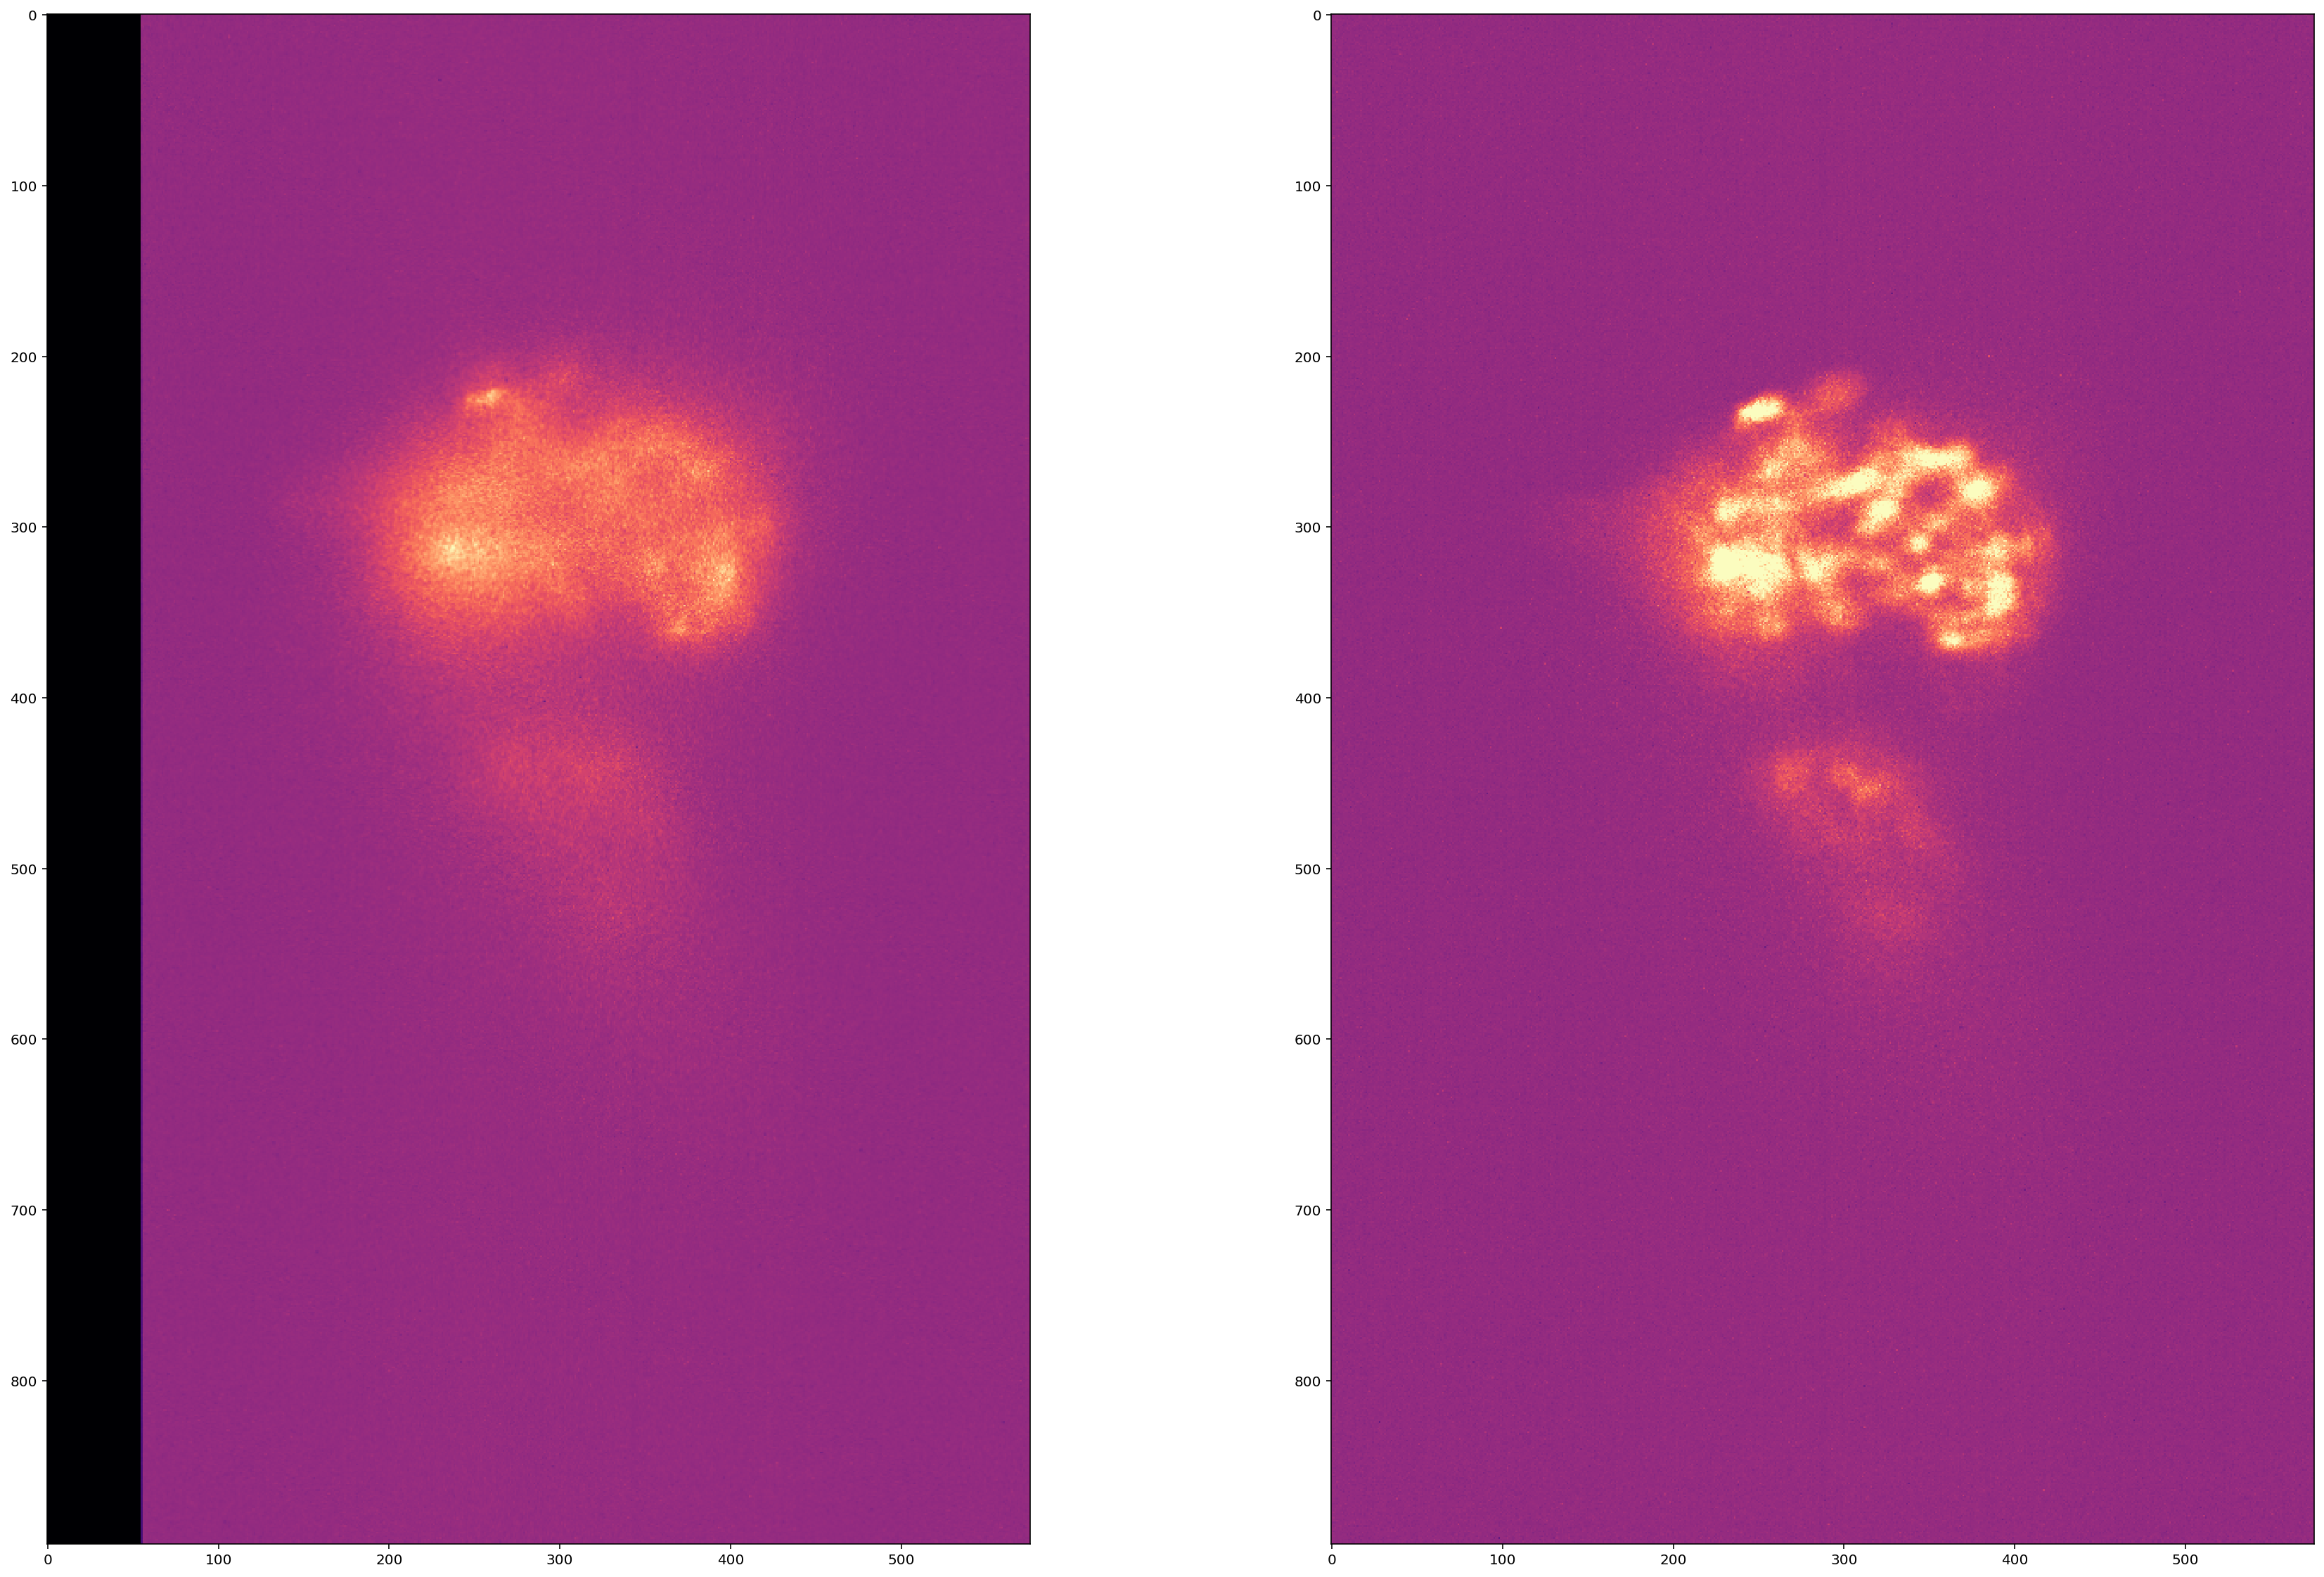

In [10]:
vmin=np.min(imgsX[4][20,...])
vmax=np.max(imgsX[4][20,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX[4][20,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY[4][20,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Since there is an artificial margin in the input and the output, we chop away the first and last 60 in the x dimension and in the y dimension

In [11]:
imgsX_chopped=[]
imgsY_chopped=[]
for i in range(len(imgsX)):
    imgsX_chopped.append(imgsX[i][:, 60:-60, 60:-60])
    imgsY_chopped.append(imgsY[i][:, 60:-60, 60:-60])

## Visualize the images again

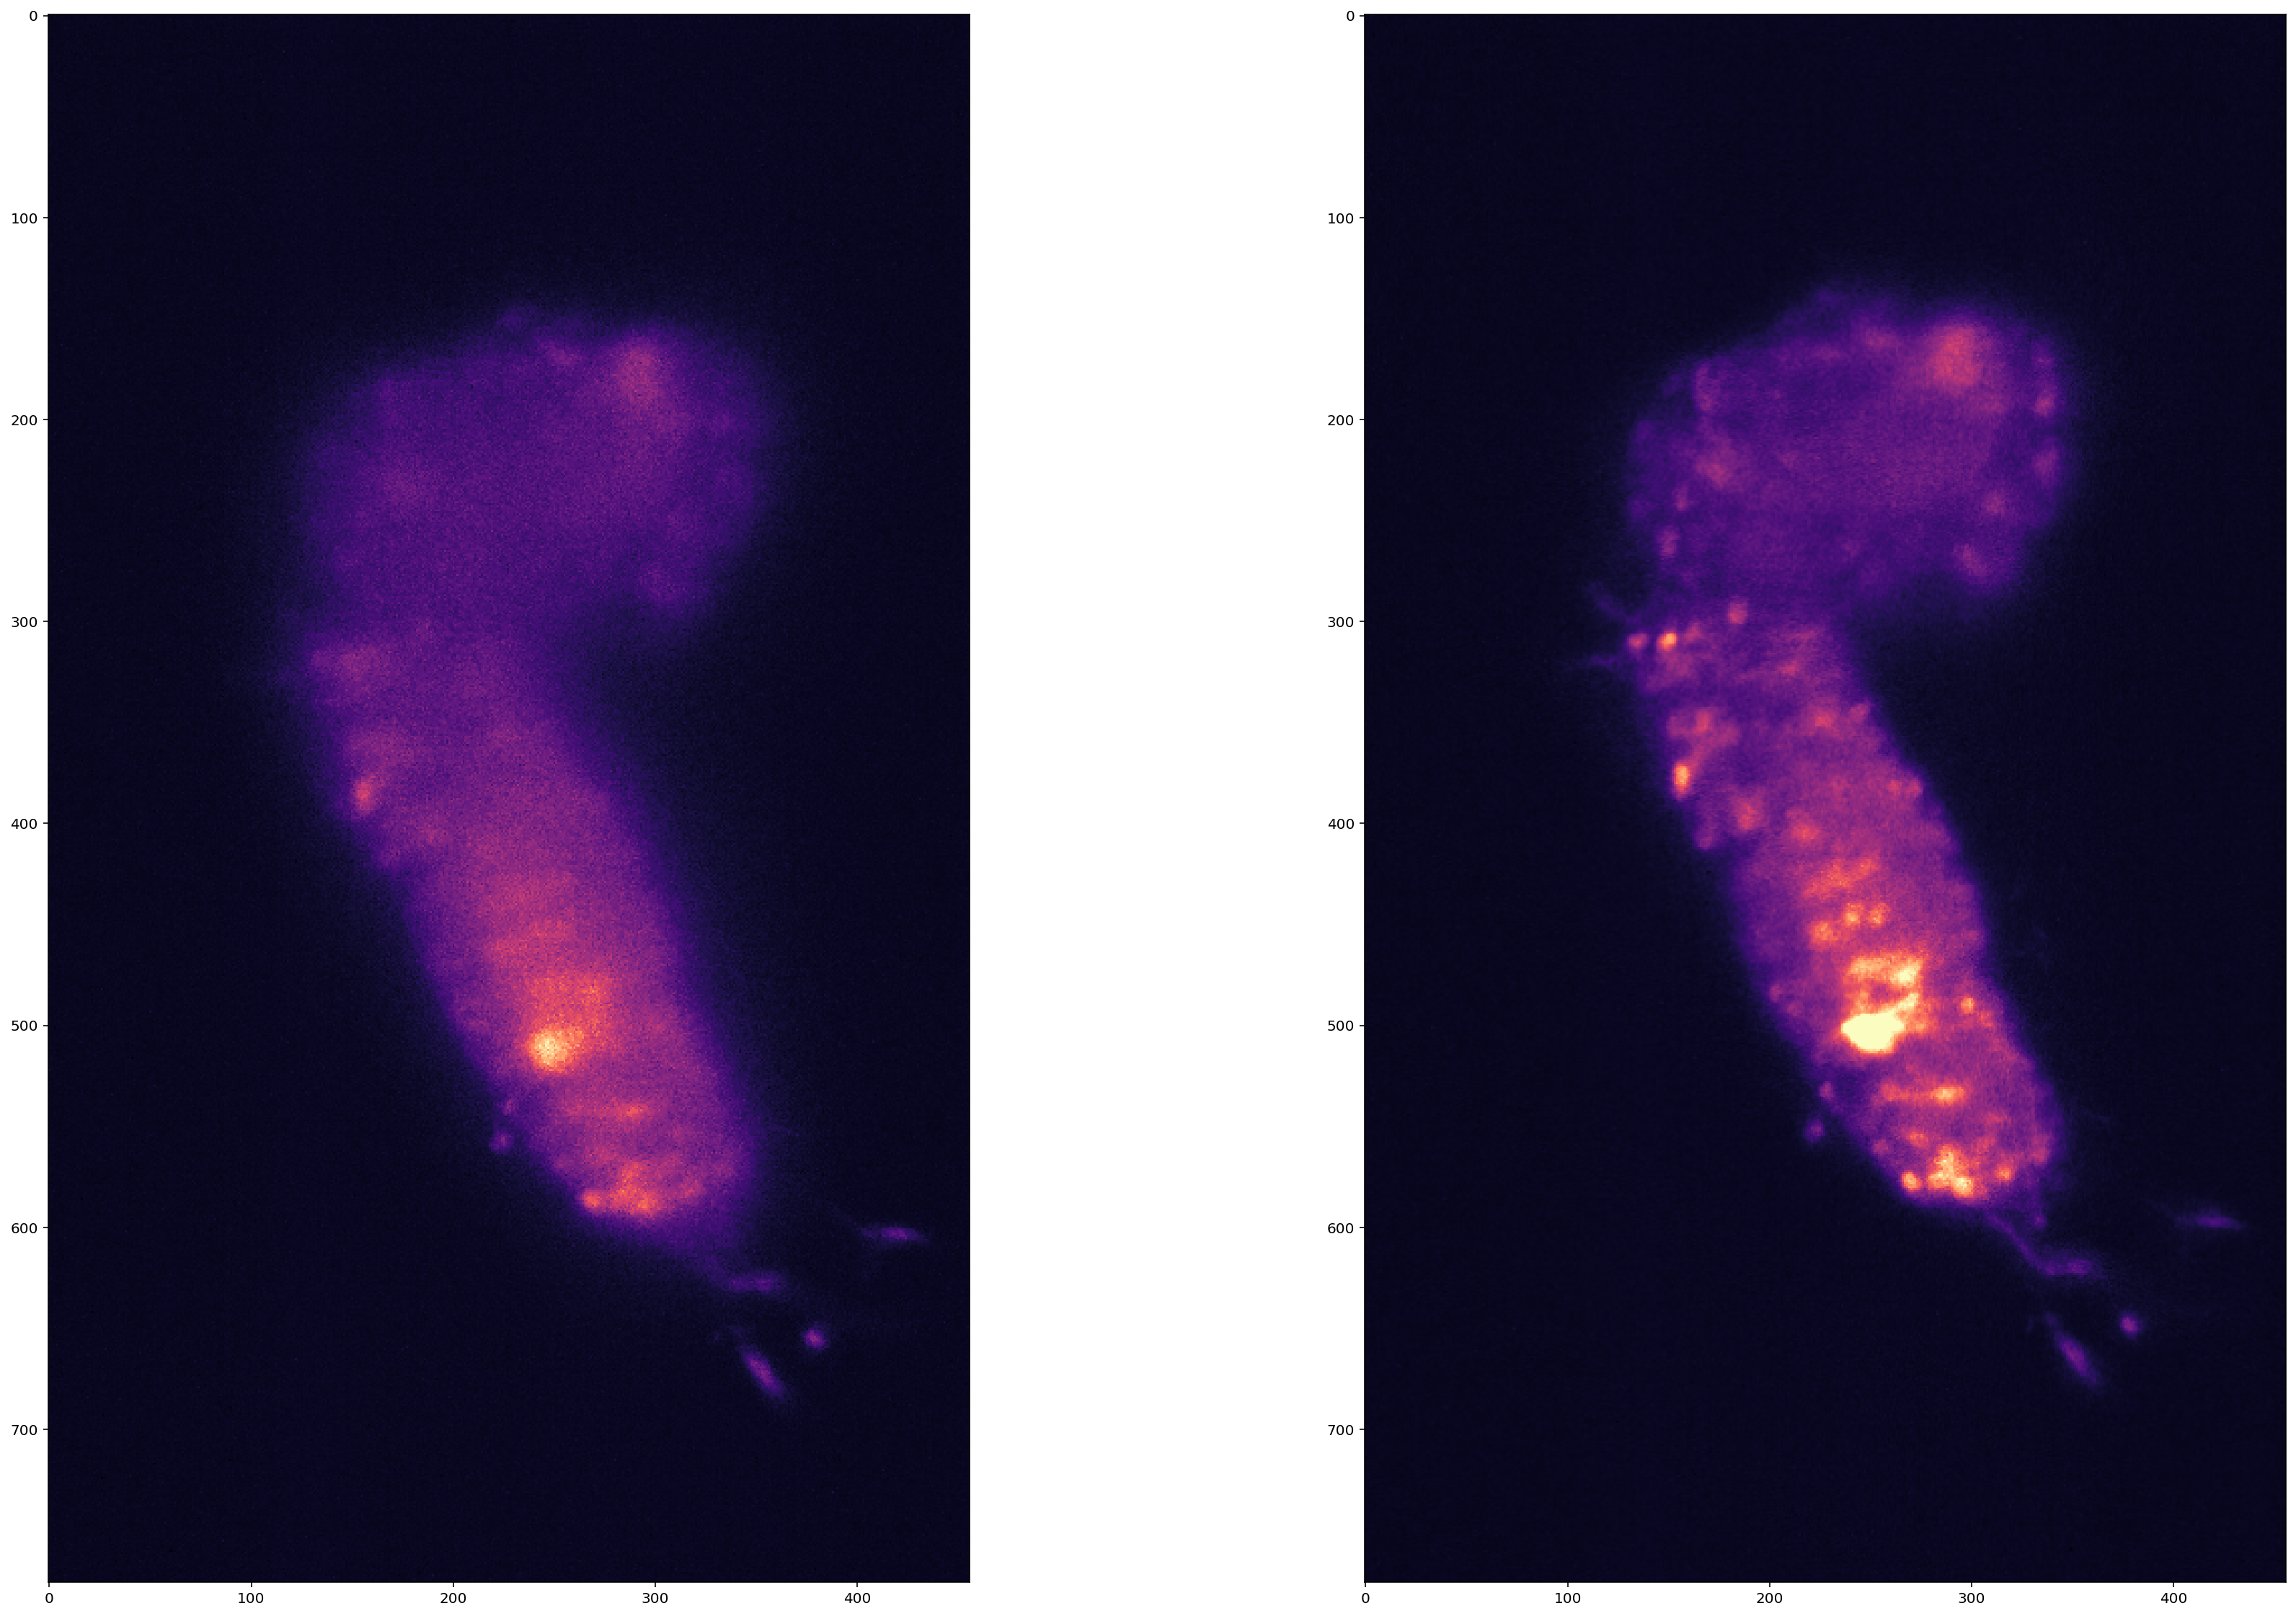

In [12]:
vmin=np.min(imgsX_chopped[15][20,...])
vmax=np.max(imgsX_chopped[15][20,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX_chopped[15][20,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY_chopped[15][20,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Also we must normalize the patches, prior to training !!

In [13]:
mean=np.mean(imgsX_chopped)
print(mean)
std=np.std(imgsX_chopped)
print(std)

119.93517382211974
43.67865414305284


## Create patches

In [14]:
imgsX_chopped=np.vstack(imgsX_chopped)
print(imgsX_chopped.shape)
imgsY_chopped=np.vstack(imgsY_chopped)
print(imgsY_chopped.shape)

(500, 776, 456)
(500, 776, 456)


In [15]:
combined=np.empty([np.shape(imgsX_chopped)[0], np.shape(imgsX_chopped)[1], np.shape(imgsX_chopped)[2], 2])
combined[..., 0]=imgsX_chopped
combined[..., 1]=imgsY_chopped
# Normalization Step
combined=(combined-mean)/std
print(combined.dtype)

float64


In [16]:
combinedList=[]
combinedList.append(combined)
print(len(combinedList))

1


## Augment is set to True

In [17]:
datagen = N2V_DataGenerator()
patches = datagen.generate_patches_from_list(combinedList, shape=(96, 96), augment=True)
print(patches.shape)

Generated patches: (128000, 96, 96, 2)
(128000, 96, 96, 2)


## Create train and validation pairs

In [18]:
X=patches[:-1000,..., 0]
X=X[..., np.newaxis]
Y=patches[:-1000, ..., 1]
Y=Y[..., np.newaxis]
X_val=patches[-1000:,..., 0]
X_val=X_val[..., np.newaxis]
Y_val=patches[-1000:, ..., 1]
Y_val=Y_val[..., np.newaxis]
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)
print("X_val shape: ", X_val.shape)
print("Y_val shape: ", Y_val.shape)

X shape:  (127000, 96, 96, 1)
Y shape:  (127000, 96, 96, 1)
X_val shape:  (1000, 96, 96, 1)
Y_val shape:  (1000, 96, 96, 1)


In [19]:
print("Datatype is:", patches[0, ..., 0].dtype)

Datatype is: float64


## Plot some examples from validation data

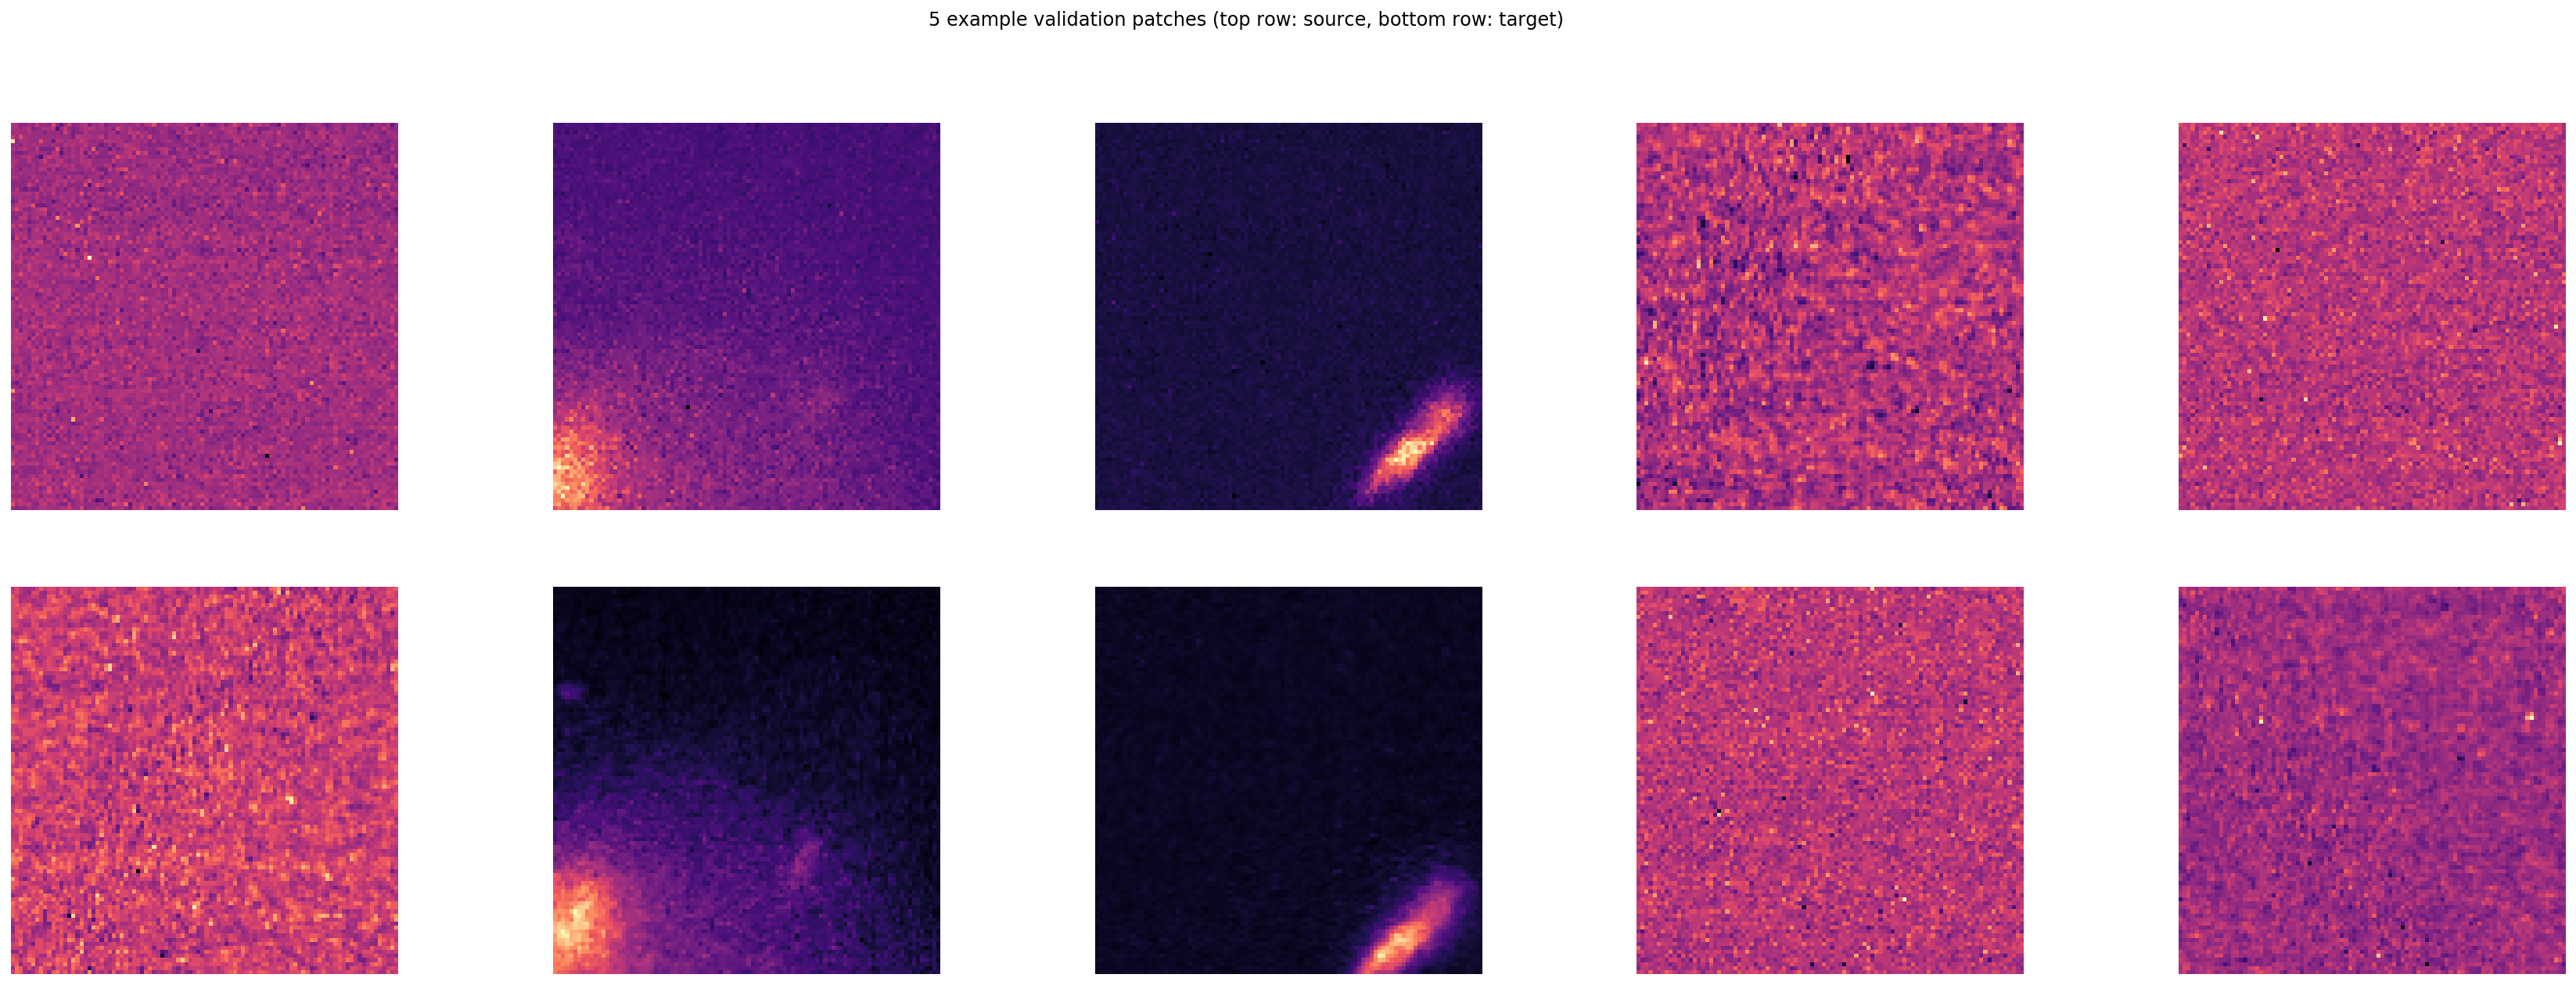

In [20]:
plt.figure(figsize=(30,10))
plot_some(X_val[150:155, ...],Y_val[150:155, ...])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [21]:
axes='SYXC'
n_channel_in=1
n_channel_out=1
config = Config(axes, n_channel_in, n_channel_out, probabilistic=False, train_steps_per_epoch=500, train_epochs=500, unet_n_first=64, unet_n_depth=3, unet_residual=False)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=500, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=500, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=3, unet_n_first=64, unet_residual=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 5,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 500,
 'train_steps_per_epoch': 500,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [22]:
model = CARE(config, 'care_2D_kellerlab_with_normalization_with_HandRegistration_float64', basedir='models')

In [23]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

/home/lalit/Desktop/02_SoftwareExecutables/anaconda3/envs/N2V368/lib/python3.6/site-packages/csbdeep/models/care_standard.py:259: UserWarning: small number of validation images (only 0.8% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100*frac_val))


Epoch 1/500
500/500 [==============================] - 49s 97ms/step - loss: 0.2149 - mse: 0.3617 - mae: 0.2149 - val_loss: 0.2008 - val_mse: 0.3217 - val_mae: 0.2008
Epoch 2/500
500/500 [==============================] - 43s 87ms/step - loss: 0.2074 - mse: 0.3490 - mae: 0.2074 - val_loss: 0.2069 - val_mse: 0.3389 - val_mae: 0.2069
Epoch 3/500
500/500 [==============================] - 43s 86ms/step - loss: 0.2116 - mse: 0.3650 - mae: 0.2116 - val_loss: 0.2049 - val_mse: 0.3179 - val_mae: 0.2049
Epoch 4/500
500/500 [==============================] - 43s 86ms/step - loss: 0.2074 - mse: 0.3519 - mae: 0.2074 - val_loss: 0.1977 - val_mse: 0.3181 - val_mae: 0.1977
Epoch 5/500
500/500 [==============================] - 44s 87ms/step - loss: 0.1941 - mse: 0.3195 - mae: 0.1941 - val_loss: 0.1930 - val_mse: 0.2985 - val_mae: 0.1930
Epoch 6/500
500/500 [==============================] - 43s 87ms/step - loss: 0.2032 - mse: 0.3525 - mae: 0.2032 - val_loss: 0.1924 - val_mse: 0.2987 - val_mae: 0.192

500/500 [==============================] - 43s 86ms/step - loss: 0.1828 - mse: 0.2967 - mae: 0.1828 - val_loss: 0.1821 - val_mse: 0.2826 - val_mae: 0.1821
Epoch 98/500
500/500 [==============================] - 44s 87ms/step - loss: 0.1878 - mse: 0.3031 - mae: 0.1878 - val_loss: 0.1809 - val_mse: 0.2711 - val_mae: 0.1809
Epoch 99/500
500/500 [==============================] - 44s 87ms/step - loss: 0.1787 - mse: 0.2809 - mae: 0.1787 - val_loss: 0.1816 - val_mse: 0.2703 - val_mae: 0.1816
Epoch 100/500
500/500 [==============================] - 44s 87ms/step - loss: 0.1860 - mse: 0.3135 - mae: 0.1860 - val_loss: 0.1821 - val_mse: 0.2811 - val_mae: 0.1821
Epoch 101/500
500/500 [==============================] - 43s 87ms/step - loss: 0.1817 - mse: 0.2832 - mae: 0.1817 - val_loss: 0.1811 - val_mse: 0.2666 - val_mae: 0.1811
Epoch 102/500
500/500 [==============================] - 44s 87ms/step - loss: 0.1862 - mse: 0.3048 - mae: 0.1862 - val_loss: 0.1811 - val_mse: 0.2744 - val_mae: 0.1811
Ep

500/500 [==============================] - 43s 86ms/step - loss: 0.1890 - mse: 0.3057 - mae: 0.1890 - val_loss: 0.1795 - val_mse: 0.2695 - val_mae: 0.1795
Epoch 192/500
500/500 [==============================] - 44s 88ms/step - loss: 0.1814 - mse: 0.2804 - mae: 0.1814 - val_loss: 0.1790 - val_mse: 0.2633 - val_mae: 0.1790
Epoch 193/500
500/500 [==============================] - 43s 86ms/step - loss: 0.1811 - mse: 0.2836 - mae: 0.1811 - val_loss: 0.1791 - val_mse: 0.2634 - val_mae: 0.1791
Epoch 194/500
500/500 [==============================] - 43s 86ms/step - loss: 0.1830 - mse: 0.2831 - mae: 0.1830 - val_loss: 0.1792 - val_mse: 0.2614 - val_mae: 0.1792
Epoch 195/500
500/500 [==============================] - 44s 87ms/step - loss: 0.1828 - mse: 0.2803 - mae: 0.1828 - val_loss: 0.1791 - val_mse: 0.2661 - val_mae: 0.1791
Epoch 196/500
500/500 [==============================] - 43s 86ms/step - loss: 0.1798 - mse: 0.2867 - mae: 0.1798 - val_loss: 0.1792 - val_mse: 0.2628 - val_mae: 0.1792


500/500 [==============================] - 43s 87ms/step - loss: 0.1825 - mse: 0.2893 - mae: 0.1825 - val_loss: 0.1791 - val_mse: 0.2639 - val_mae: 0.1791
Epoch 285/500
500/500 [==============================] - 43s 87ms/step - loss: 0.1861 - mse: 0.3050 - mae: 0.1861 - val_loss: 0.1791 - val_mse: 0.2639 - val_mae: 0.1791
Epoch 286/500
500/500 [==============================] - 43s 86ms/step - loss: 0.1819 - mse: 0.2815 - mae: 0.1819 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791
Epoch 287/500
500/500 [==============================] - 43s 87ms/step - loss: 0.1815 - mse: 0.2835 - mae: 0.1815 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791
Epoch 288/500
500/500 [==============================] - 43s 86ms/step - loss: 0.1811 - mse: 0.2806 - mae: 0.1811 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791
Epoch 289/500
500/500 [==============================] - 43s 86ms/step - loss: 0.1829 - mse: 0.2827 - mae: 0.1829 - val_loss: 0.1791 - val_mse: 0.2641 - val_mae: 0.1791


500/500 [==============================] - 43s 86ms/step - loss: 0.1796 - mse: 0.2778 - mae: 0.1796 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791
Epoch 377/500
500/500 [==============================] - 43s 86ms/step - loss: 0.1834 - mse: 0.2840 - mae: 0.1834 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791
Epoch 378/500
500/500 [==============================] - 43s 86ms/step - loss: 0.1779 - mse: 0.2769 - mae: 0.1779 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791
Epoch 379/500
500/500 [==============================] - 43s 87ms/step - loss: 0.1812 - mse: 0.2837 - mae: 0.1812 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791

Epoch 00379: ReduceLROnPlateau reducing learning rate to 4.768371461572052e-11.
Epoch 380/500
500/500 [==============================] - 43s 87ms/step - loss: 0.1821 - mse: 0.2817 - mae: 0.1821 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791
Epoch 381/500
500/500 [==============================] - 43s 86ms/step - loss: 0.1850 - 

500/500 [==============================] - 43s 86ms/step - loss: 0.1824 - mse: 0.2848 - mae: 0.1824 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791
Epoch 469/500
500/500 [==============================] - 43s 87ms/step - loss: 0.1832 - mse: 0.2853 - mae: 0.1832 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791

Epoch 00469: ReduceLROnPlateau reducing learning rate to 9.313225510882914e-14.
Epoch 470/500
500/500 [==============================] - 43s 85ms/step - loss: 0.1792 - mse: 0.2799 - mae: 0.1792 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791
Epoch 471/500
500/500 [==============================] - 43s 86ms/step - loss: 0.1804 - mse: 0.2715 - mae: 0.1804 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791
Epoch 472/500
500/500 [==============================] - 43s 86ms/step - loss: 0.1839 - mse: 0.2970 - mae: 0.1839 - val_loss: 0.1791 - val_mse: 0.2640 - val_mae: 0.1791
Epoch 473/500
500/500 [==============================] - 43s 86ms/step - loss: 0.1902 - 

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


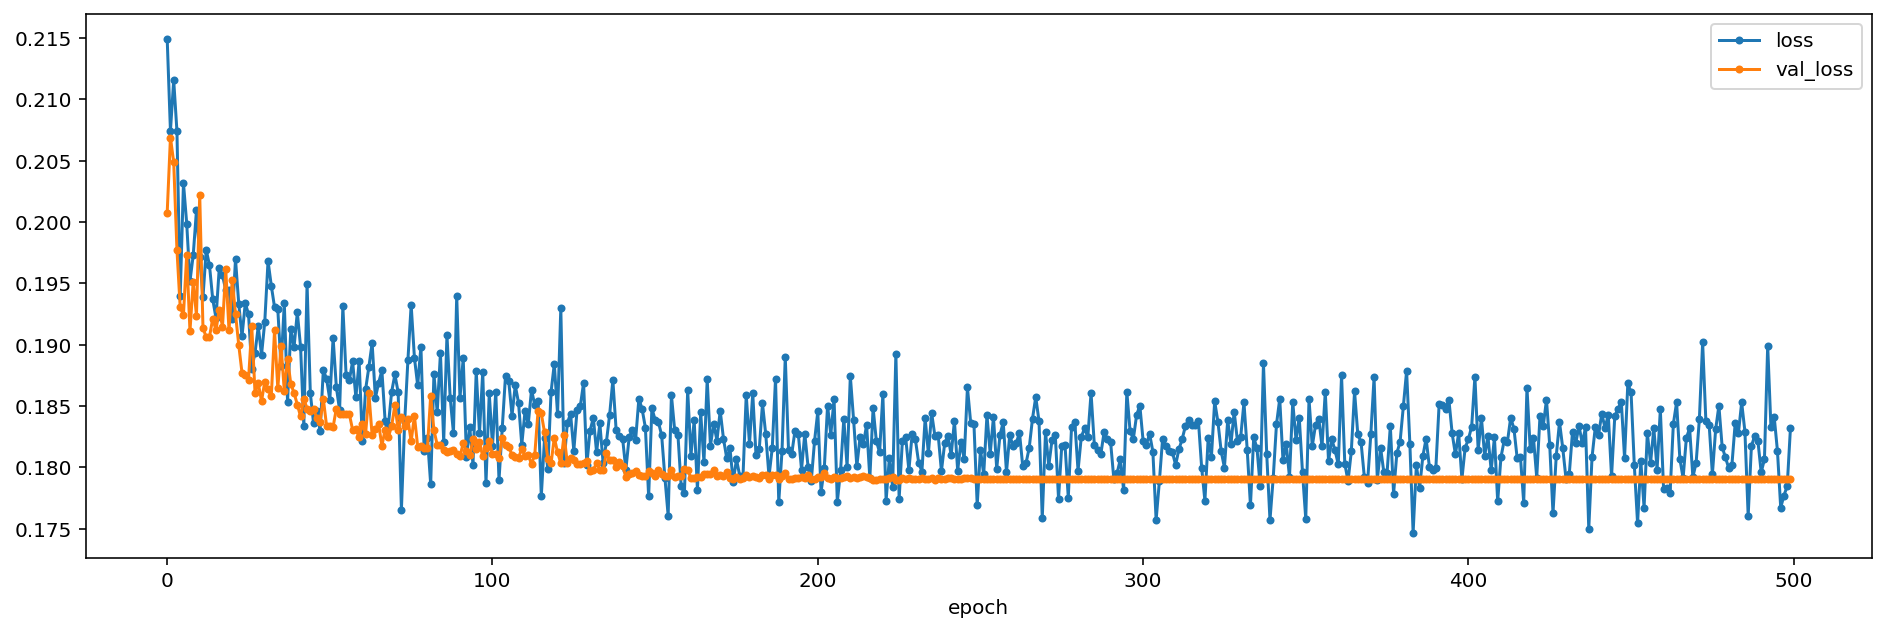

In [24]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);